# Implementación PointNet en Keras, Tensorflow 2.0

## Lectura y preparación del conjunto de datos

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import re
import matplotlib.pyplot as plt
import random as rand


from pathlib import Path
from sklearn.model_selection import train_test_split


### Cargar y Leer archivos _.csv_ de cada subconjunto

In [3]:
# Linux

#path_x_train = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/x_train/"
#path_y_train = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/y_train/"
#path_x_val = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/x_val/"
#path_y_val = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/y_val/"

# MacOS

path_x_train = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/"
path_y_train = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/y_train/"
path_x_val = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_val/"
path_y_val = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/y_val/"

file_list_x_train = sorted(os.listdir(path_x_train))
file_list_y_train = sorted(os.listdir(path_y_train))
file_list_x_val = sorted(os.listdir(path_x_val))
file_list_y_val = sorted(os.listdir(path_y_val))

X_train = []
Y_train = []
X_val = []
Y_val = []

# Función para leer archivos con manejo de errores de codificación
def read_csv_safe(filepath, encoding='utf-8'):
    try:
        return pd.read_csv(filepath, encoding=encoding)
    except UnicodeDecodeError:
        # Intenta con otra codificación si utf-8 falla
        return pd.read_csv(filepath, encoding='latin1')

for file in file_list_x_train:
    df_x_train = read_csv_safe(path_x_train + file)
    X_train.append(df_x_train)

for file in file_list_y_train:
    df_y_train = pd.DataFrame()
    df_y_train['sem_label'] = read_csv_safe(path_y_train + file)
    Y_train.append(df_y_train)

for file in file_list_x_val:
    df_x_val = read_csv_safe(path_x_val + file)
    X_val.append(df_x_val)

for file in file_list_y_val:
    df_y_val = pd.DataFrame()
    df_y_val['sem_label'] = read_csv_safe(path_y_val + file)
    Y_val.append(df_y_val)

In [4]:
# Estudio de clases

Y_train_concat = pd.concat(Y_train)
Y_val_concat = pd.concat(Y_val)
Y_concat = pd.concat(([pd.DataFrame(Y_train_concat), pd.DataFrame(Y_val_concat)]))

clases_unicas_train = Y_train_concat['sem_label'].unique()
clases_unicas_val = Y_val_concat['sem_label'].unique()
clases_unicas = set([int(x) for x in np.concatenate((clases_unicas_train, clases_unicas_val))])

print("Clases definidas en el conjunto de entrenamiento: ", clases_unicas_train)
print("\nClases definidas en el conjunto de validación: ",clases_unicas_val)
print("\nClases definidas en el conjunto de datos: ",clases_unicas)
print(f"Faltan {64 - len(clases_unicas)} clases en el conjunto de datos")

Clases definidas en el conjunto de entrenamiento:  [59 23 50 17 16 45 51 38 41 11 8 58 47 46 57 0 31 27 28 36 4 12 6 14 40 29
 55 37 34 22 25 13 32 42 30 24 60 54 39 3 21 20 10 33 5 26 19 48 2 18 43 1
 61 15 49 35 7 9]

Clases definidas en el conjunto de validación:  [31 59 51 28 17 27 23 41 50 0 8 4 6 38 16 11 45 57 58 47 46 29 40 55 12 24
 2 5 42 14 33 39 37 3 22 48 36 13 34 21 10 1 20 43 25 9 19 15 32 49 7 35
 30 54 60]

Clases definidas en el conjunto de datos:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 57, 58, 59, 60, 61}
Faltan 6 clases en el conjunto de datos


In [5]:
# Calcula las clases faltantes en Xtrain
clases_faltantes_train = list(set(clases_unicas_train) - set(clases_unicas_val))
clases_unicas_df = np.concatenate((clases_unicas_train, clases_faltantes_train))

# Calcula las clases existentes en el conjunto de datos
clases_unicas_df = sorted(set(clases_unicas_df))

print("En el conjunto de datos hay: ", len(clases_unicas), "clases únicas")


En el conjunto de datos hay:  58 clases únicas


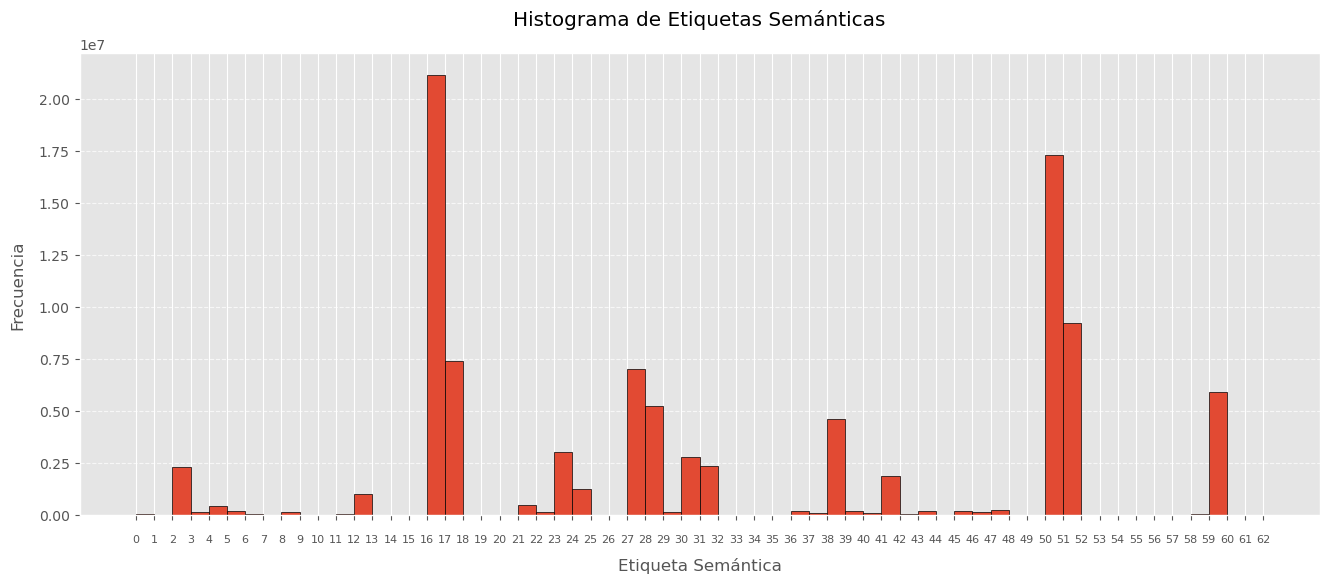

In [6]:
# Histograma de frecuencia de clases

from matplotlib.ticker import FuncFormatter

# Crear el histograma
plt.figure(figsize=(16, 6))
plt.style.use('ggplot')
plt.hist(Y_concat['sem_label'], 
         bins=np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 2), 
         edgecolor='k', 
         alpha=1, 
         align='mid')

# Chatgpt code
# Configurar el formateador para el eje Y
#ax = plt.gca()
#formatter = FuncFormatter(lambda x, _: f"{int(x):,}")  # Formato con separadores de miles
#ax.yaxis.set_major_formatter(formatter)  # Aplicar el formateador

# Personalización del gráfico
plt.title("Histograma de Etiquetas Semánticas", pad=20)
plt.xlabel("Etiqueta Semántica", labelpad=10)
plt.ylabel("Frecuencia", labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar las marcas del eje X en incrementos de 1
x_ticks = np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 2, 1)
plt.xticks(x_ticks, fontsize=8)

# Ajustar padding de los x_ticks
plt.gca().tick_params(axis='x', pad=10)  # Aumenta el espacio entre los ticks y el eje

# Mostrar el gráfico
plt.show()

In [7]:
# Clases que faltan en el conjunto de datos

GOOSE_CLASSES = [i for i in range(0, 64)]

# Calcular clases faltantes

clases_faltantes = [i for i in GOOSE_CLASSES if i not in clases_unicas]

print(f"Hay {len(clases_faltantes)} clases que no están representadas en este conjunto de datos: ")
print(clases_faltantes)


Hay 6 clases que no están representadas en este conjunto de datos: 
[44, 52, 53, 56, 62, 63]


In [8]:
from sklearn.model_selection import train_test_split

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.2, random_state=6)

158

In [10]:
print(f"El conjunto de entrenamiento consta de {len(X_train)} nubes de puntos")
print(f"El conjunto de validación consta de {len(X_val)} nubes de puntos")
print(f"El conjunto de pruebas consta de {len(X_test)} nubes de puntos")

El conjunto de entrenamiento consta de 765 nubes de puntos
El conjunto de validación consta de 158 nubes de puntos
El conjunto de pruebas consta de 40 nubes de puntos
